## 資料前處理

In [23]:
import matplotlib.pyplot as plt
import os, PIL
import numpy as np
digits = []
labels = []
basewidth = 50
cnt = 0 

for i in range(0,10):
    for img in os.listdir('image_sample/{}/'.format(i)):
        pil_image = PIL.Image.open('image_sample/{}/{}'.format(i, img)).convert('1') 
    
        wpercent = (basewidth/float(pil_image.size[0]))
        hsize = int((float(pil_image.size[1])*float(wpercent)))
        img = pil_image.resize((basewidth,hsize), PIL.Image.ANTIALIAS)        
        
        cnt = cnt + 1
        digits.append([pixel for pixel in iter(img.getdata())])
        labels.append(i)

## 標準化資料

In [24]:
from sklearn.preprocessing import StandardScaler
import numpy
digit_ary  = numpy.array(digits)

scaler = StandardScaler()
scaler.fit(digit_ary)
X_scaled = scaler.transform(digit_ary)

c:\programdata\anaconda3\envs\opencvtest\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


## 建立模型

In [3]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30), activation='logistic', max_iter = 10000)
mlp.fit(X_scaled,labels)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 30, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

## 將模型儲存成pickle

In [4]:
from sklearn.externals import joblib
joblib.dump(mlp, 'captcha.pkl') 

## 從pickle 讀取模型

In [25]:
clf = joblib.load('captcha.pkl') 

## 存儲驗證碼

In [32]:
import requests
rs  = requests.session()
res = rs.get('http://gcis.nat.gov.tw/pub/cmpy/cmpyInfoListAction.do')
with open('kaptcha.jpg', 'wb') as f:
    res2 = rs.get('http://gcis.nat.gov.tw/pub/kaptcha.jpg')
    f.write(res2.content)


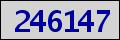

In [33]:
from PIL import Image
Image.open('kaptcha.jpg')

## 建立驗證碼存儲與切割函式

In [34]:
import requests
import numpy
from matplotlib import pyplot as plt
from datetime import datetime
import time
import cv2
from sklearn.preprocessing import StandardScaler
basewidth = 50
def saveKaptcha(image, dest):
    scaler = StandardScaler()
    pil_image = PIL.Image.open(image).convert('RGB') 
    open_cv_image = numpy.array(pil_image) 
    imgray = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted([(c, cv2.boundingRect(c)[0]) for c in contours], key=lambda x:x[1])
    ary = []
    for (c,_) in cnts:
        (x,y,w,h) = cv2.boundingRect(c)
        if w >= 15 and h == 24:
            ary.append((x,y,w,h) )
    data = []
    for idx, (x,y,w,h) in enumerate(ary):
        fig = plt.figure()
        roi = open_cv_image[y:y+h, x:x+w]
        thresh = roi.copy()
        plt.imshow(thresh)
        plt.savefig(os.path.join(dest, '{}.jpg'.format(idx)), dpi=100)




In [35]:
saveKaptcha('kaptcha.jpg', 'imagedata')

c:\programdata\anaconda3\envs\opencvtest\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


## 辨識驗證碼

In [36]:
def predictKaptcha(dest):
    data = []
    for idx, img in enumerate(os.listdir(dest)):
        pil_image = PIL.Image.open(os.path.join(dest,'{}'.format(img))).convert('1') 
        wpercent = (basewidth/float(pil_image.size[0]))
        hsize = int((float(pil_image.size[1])*float(wpercent)))
        img = pil_image.resize((basewidth,hsize), PIL.Image.ANTIALIAS)
        data.append([pixel for pixel in iter(img.getdata())])
    scaler.fit(data)
    data_scaled = scaler.transform(data)
    return clf.predict(data_scaled)

In [37]:
predictKaptcha('imagedata')

array([2, 4, 6, 1, 4, 7])

## 撰寫網路爬蟲

c:\programdata\anaconda3\envs\opencvtest\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[6 3 9 4 7 5]


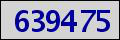

In [41]:
import requests
rs  = requests.session()
res = rs.get('http://gcis.nat.gov.tw/pub/cmpy/cmpyInfoListAction.do')
with open('kaptcha.jpg', 'wb') as f:
    res2 = rs.get('http://gcis.nat.gov.tw/pub/kaptcha.jpg')
    f.write(res2.content)
saveKaptcha('kaptcha.jpg', 'imagedata') 
kaptcha = predictKaptcha('imagedata')

print(kaptcha)
Image.open('kaptcha.jpg')



In [42]:
payload = {
'method':'query',
'otherEnterFlag':'false',
'useEUC':'N',
'isShowEUC':'N',
'queryKey':'sed50975',
'selCmpyType':'1',
'selQueryType':'2',
'queryStr':'24567645',
'brBanNo':'',
'imageCode':'053350'  
}
headers ={
'Referer':'http://gcis.nat.gov.tw/pub/cmpy/cmpyInfoListAction.do',
'User-Agent':'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36'   
} 
payload['imageCode'] = ''.join([str(ele) for ele in kaptcha.tolist()])
res3 = rs.post('http://gcis.nat.gov.tw/pub/cmpy/cmpyInfoListAction.do', data = payload, headers = headers)
res3.encoding = 'cp950'

print(res3.text)








<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html>
<head>
<meta name="DC.Title" content="公司及分公司基本資料查詢" />
<meta name="DC.Creator" content="" />
<meta name="DC.Subject" content="" />
<meta name="DC.Description" content="" />
<meta name="DC.Contributor" content="" />
<meta name="DC.Type" content="網頁" />
<meta name="DC.Format" content="Microsoft Internet Explorer" />
<meta name="DC.Source" content="" />
<meta name="DC.Language" content="繁體中文" />
<meta name="DC.Coverage" content="" />
<meta name="DC.Publisher" content="經濟部" />
<meta name="DC.Date" content="2008-05-13" />
<meta name="DC.Identifier" content="URL"/>
<meta name="DC.Relation" content="" />
<meta name="DC.Rights" content="" />
<meta name="Category.Theme" content="500"/>
<meta name="Category.Cake" content="700"/>
<meta name="Category.Service" content="620"/>
<meta name="Keywords" content="財政經濟, 經濟貿易, 公司設立" />
<meta http-equiv="Content-Type" conte